# NLP for articles

In [1]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

import string
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf

In [ ]:
from ipynb.fs.defs.functions import texts_to_tokens

In [3]:
porter = PorterStemmer()

stop_words = stopwords.words('english')

stop_words += ['investorsobserv', 'lp', 'com', 'http', 'www',
               'said', 'compani', 'year', 'u', 'vaccin', 'cnbc', 'billion',
               'quarter', 'covid', 'also', 'stock', 'market', 'share', 'three',
               'million', 'would', 'peopl', 'ha', 'wa', 'thi', 'last', 'month', 'hi',
               'time', 'like', 'week', 'say', 'could', 'first', 'wednesday',
               'second', 'two', 'one', 'pandem', 'thursday', 'day', 'hous', 'per', 'tuesday',
               
               'servic', 'offer', 'look', 'work', 'near', 'staf', 'work', 'accord', 'report',
               'countri', 'make', 'nation', 'industri', 'invest', 'get', 'world', 'includ', 'presid',
               'financi', 'public', 'econom', 'economi', 'data', 'technolog', 'product', 'consult',
               'firm', 'global', 'sourc', 'creat', 'career', 'talent', 'survey', 'manag', 'demand', 
               'attract', 'base', 'privat', 'tax', 'investor', 'read', 'come', 'secur', 'state', 'rate', 
               'new', 'bank', 'price', 'sinc', 'plan', 'group', 'inc', 'high', 'expect', 'risk', 'increas',
               'trade', 'fund', 'may', 'back', 'end', 'still', 'recent', 'go', 'busi', 'need', 'polici',
               'case', 'offic', 'assist', 'much', 'use', 'mani', 'growth', 'analyst', 'earlier', 'even', 'bloomberg',
               'befor', 'call', 'help', 'statement', 'see', 'american', 'offici', 'way', 'ani', 'senat', 'follow', 'ad',
               'set', 'declin', 'tech', 'juli', 'move', 'half', 'becaus', 'june', 'sector', 'gain', 'support',
               'among', 'chief', 'hold', 'continu', 'issu', 'start', 'friday', 'regulatori', 'rais', 'wrote', 'rule', 
               'well', 'take', 'onli', 'target', 'cost', 'oper', 'spend', 'deal', 'next', 'index', 'execut', 'sale', 'major',
               'number', 'provid', 'dure', 'capit', 'suppli', 'asset', 'estim', 'return', 'key', 'biggest', 'show', 'buy',
               'author', 'regul', 'foreign', 'record', 'low', 'want', 'intern', 'order', 'requir', 'long', 'put', 'level',
               'meet', 'restrict', 'infrastructur', 'alreadi', 'research', 'administr', 'court', 'equiti', 'delta',
               'decis', 'co', 'region', 'file', 'earn', 'rise', 'potenti', 'revenu', 'remain', 'variant', 'develop', 'corp',
               'consid', 'citi', 'system', 'central', 'keep', 'releas', 'bill', 'comment', 'consum', 'stabil', 'loss',
               'ipo', 'valu', 'profit', 'canada', 'sell', 'sign', 'run', 'project', 'turn', 'term', 'financ', 'interest',
               'govern', 'feder', 'job', 'higher', 'produc', 'forecast', 'custom', 'led', 'media', 'process', 'post',
               'money', 'due', 'larg', 'top', 'exchang', 'unit', 'open', 'point', 'close', 'former', 'treasuri', 'announc',
               'purchas', 'pay', 'fell', 'largest', 'initi', 'worker', 'crackdown', 'big', 'made', 'commerc', 'platform',
               'domain', 'name', 'analyt', 'place', 'right', 'white', 'mine', 'though', 'segment', 'headquart', 'solut', 
               'found', 'corpor', 'manufactur', "retail", 'commerci', 'brand', 'variou', 'addit', 'loan', 'aug', 'reuter',
               'compar', 'edit', 'total'
               ]

# Load data

In [9]:
articles = pickle.load(open("bloomberg_data.pkl", "rb"))
companis_info = pd.read_csv( "./Companies_Info/companies_name_description.csv" )
articles.shape, companis_info.shape

((6, 5), (1600, 2))

# Preprocessing data

In [22]:
# remove atricles without text
articles = articles[ articles["text"] != "" ]
# select artiles without politics category
articles = articles[ articles["category"] != "/politics" ]

In [28]:
# convert text to tokens
articles["text_stem"] = articles['text'].apply( lambda text : texts_to_tokens( text , stop_words ) )
companis_info["text_stem"] = companis_info['description'].apply( lambda text : texts_to_tokens( text , stop_words ) )

## Companies to matrix

In [12]:
corpus = companis_info["text_stem"].values
# оставляет все не тронутым
vectorizer = CountVectorizer(analyzer=lambda x: x)
vectorizer.fit(corpus)

X = vectorizer.transform(corpus)

In [13]:
# a df with columns of words and comapnies in indexs ( if word exist in description set 1 else 0)
companies_tokenize_df = pd.DataFrame( index = companis_info["name"].values , 
                                     columns = vectorizer.get_feature_names(), 
                                     data = X.toarray() )

### Normalize data

In [14]:
data_normalize = [ vector / np.linalg.norm(vector) for vector in companies_tokenize_df.values ]

companies_tokenize_df_normalize = pd.DataFrame( index = companis_info["name"].values , 
                                     columns = vectorizer.get_feature_names(), 
                                     data = data_normalize )

# Plot words friquency

In [69]:
import itertools
merged = list(itertools.chain(*list( corpus )))
counter = pd.Series( merged ).value_counts()

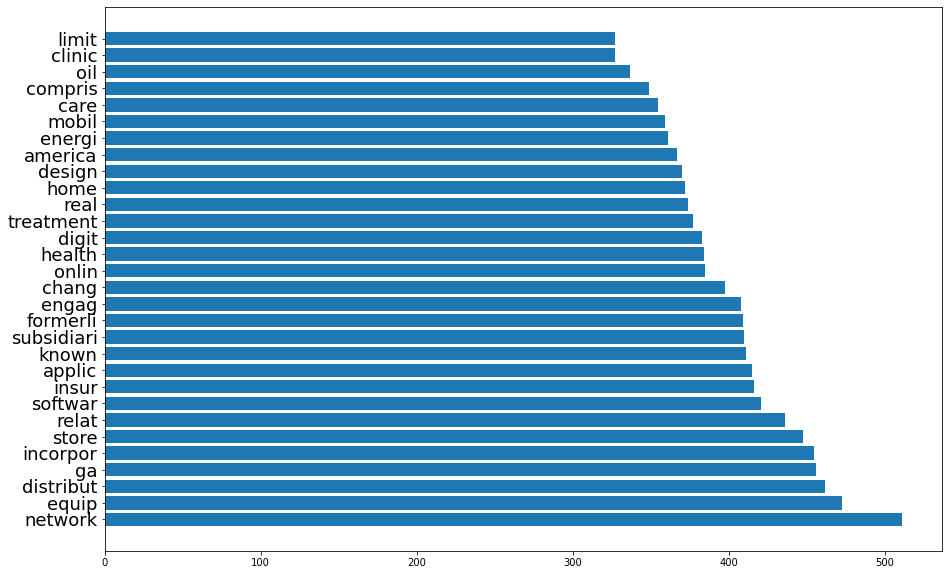

In [71]:
plt.figure(figsize=(15,10))
plt.yticks(fontsize=18)
plt.barh( counter.index, counter.values);

# Find article by company description

In [5]:
def preprocessing_text( text, vectorizer):
    """ Turn input text into vector of [1..,..0] ( 1 if word into text, 0 if out ), than normalized the vector 
    
        Args:
            text ([string]) : [given text]
            vectorizer ([sklearn.feature_extraction.text CountVectorizer]) : [transform array ot words into [1..,..0]]
            
        Return:
            [np.array float] : [the normalized vector for text]
    """
    
    # convert text to tokens
    search_stems       = texts_to_tokens( text , stop_words )

    # convers the array of tokens to [0,1] array
    search_vector      = vectorizer.transform( [search_stems] )
    search_vector      = search_vector.toarray()[0]
    # normalize [0,1] vector
    search_vector_norm = search_vector / np.linalg.norm(search_vector)
    search_vector_norm = np.array( search_vector_norm )
    
    return search_vector_norm

In [3]:
def search_text_into_corpus( corpus, text_vector ):
    """ Find similar text into corpus for the given text
    
        Args:
            corpus ([np.array[np.array float]]) : [contain float vectors]
            text_vector ([array float]) : [float vector (same shape as the corpus row)]
            
        Return:
            [array int] : [indexs of 10 most similar vectors]
            
        Examples:
            >>> import numpy as np
            >>> search_text_into_corpus( np.array( [[1, 0, 0], [0, 1, 0], [0, 0, 1]]), [0, 1, 0.1] )
            array([1, 2, 0])
    """
    
    # counting of distances between article and companies
    dist_euclide = [ np.linalg.norm(vector-text_vector) for vector in corpus]
    dist_euclide = np.array( dist_euclide )
    
    # select the first 10, and return indexs  
    sort_cnt  = 10
    sort_euclide = dist_euclide.argsort()[:sort_cnt]
    return sort_euclide
    
#     sort_cosine  = dist_cosine.argsort()[:sort_cnt]
#     dist_cosine = [np.arccos( np.dot(text_vector,search_vector_norm) ) for text_vector in companies_tokenize_df_normalize.values]
#     dist_cosine = np.array( dist_cosine )

In [7]:
def search_process( search_test ):  
    search_vector_norm = preprocessing_text( search_test, vectorizer )
    sort_euclide = search_text_into_corpus( companies_tokenize_df_normalize.values, search_vector_norm )
    return companis_info.iloc[ sort_euclide ]

# Word2vec search

In [143]:
descriptions_words_extend_df_vector = pd.read_pickle( "./Preparing_search_data/descriptions_words_extend_vectors.pkl" )
companis_info = pd.read_csv( "./Companies_Info/companies_name_description.csv" )

In [86]:
def text_to_vector( text_stem ):
    # get words in article, which in model    
    common_words = descriptions_words_extend_df_vector[ descriptions_words_extend_df_vector["word"].isin( text_stem ) ]
    # then sum the vectors and normalize    
    common_words_vectors_sum = common_words["vector"].sum()
#     common_words_vectors_sum = common_words_vectors_sum / np.linalg.norm(common_words_vectors_sum)
    return common_words_vectors_sum

In [87]:
companis_info["text_stem"] = companis_info["description"].apply( lambda x : texts_to_tokens(x, stop_words) )
companis_info["vector"] = companis_info["text_stem"].apply( text_to_vector )

In [88]:
article_vector = text_to_vector( articles["text_stem"].values[10] )

In [89]:
dist_euclide = [ np.linalg.norm(article_vector-company_vector_norm) for company_vector_norm in companis_info["vector"].values ]
dist_euclide = np.array( dist_euclide )

In [90]:
sort_companies_cnt  = 10

sort_companies_euclide = dist_euclide.argsort()[:sort_companies_cnt]

# Server

In [18]:
from werkzeug.wrappers import Request, Response
from IPython.core.display import HTML
from IPython.display import clear_output
from flask import Flask
from flask import request
import json

In [21]:
def return_html_render( articles, companies ):
    """ Create a html template for given articles and companies
        
        Args: 
            articles ([dict array]) : [dict with url, date, title, text]
            companies ([array array[string]]) : [array with companies name and description ( 0 and 1 index)]
        
        Return:
            [string] : [html text]
    """
    
    render_form = ''
    for index, article in enumerate( articles ):
        
        # the template of html for similar companies
        render_companies = ''
        for company in companies[index]:
            html_form_companies = '''   <details> 
                                            <summary><h2>Company {}</h1></summary> 
                                            <br/>
                                            <div style="margin-left:30px">
                                                {}
                                            </div>
                                        </details> '''.format( company[0], company[1] )
            render_companies += html_form_companies
        
        # the template of html for articles
        html_form_rticle = '''  <details> 
                                    <summary><h1>Article {}</h1></summary> 
                                    <br/>
                                    <div style="margin-left:30px">
                                        <a href={} >{}</a>
                                        {}
                                        <h3 style="text-align: center">{}</h3>
                                        {}
                                        {}
                                    </div>
                                </details> '''.format(index+1, article["url"], article["url"], article["date"],
                                                      article["title"], article["text"], render_companies )
        
        render_form += html_form_rticle
        
    
    return render_form

In [41]:
articles = []
companies = []

In [ ]:
app = Flask(__name__)

@app.route("/", methods=["POST"])
def serv():
    
    global articles, companies
    data = request.json
    data = json.loads( data )
    
    # pass advert articles    
    if data not in articles and "politic" not in data["category"] and "stocks" not in data["url"] and "prices rise" not in data["title"] :
        
        # select only last 15 articles and show   
        articles.append( data )
        articles = articles[-15:]
        
        companies.append( search_process( data["text"] ).values )
        companies = companies[-15:]

        clear_output(wait=True)
        display(HTML(return_html_render( articles[::-1] , companies[::-1] )  ))
        
    return "200"

if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 9000, app)

127.0.0.1 - - [27/Aug/2021 22:25:51] "POST / HTTP/1.1" 200 -
